<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/Abhilash_2D_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt


In [126]:
def periodic_particles(pos_x, pos_y, length):
    for i in range(len(pos_x)):
        if pos_x[i] >= length:
            pos_x[i] -= length
        elif pos_x[i] < 0:
            pos_x[i] += length

        if pos_y[i] >= length:
            pos_y[i] -= length
        elif pos_y[i] < 0:
            pos_y[i] += length

    return pos_x, pos_y

In [127]:
def charge_density(pos_x, pos_y, dx, dy, length):    #DONE
    # pos_x, pos_y = periodic_particles(pos_x, pos_y, length)
    charge_density = np.zeros((int(length / dx) +1 , int(length / dy) + 1))

    # FIFTH: LOOPING
    for p in range(len(pos_x)):
        pos_x, pos_y = periodic_particles(pos_x, pos_y, length)
        # GRID POINT FINDER
        i = int(pos_x[p] / dx)
        j = int(pos_y[p] / dy)
        #print('position_x:\n', pos_x)
        #print('position_y:\n', pos_y)
        # FRACTION FINDER
        x_frac = (pos_x[p] - (i * dx)) / dx
        y_frac = (pos_y[p] - (j * dy)) / dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1
        #print(p)
        #print(pos_x[p])
        #print(pos_y[p])
        charge_density[i%length][j%length]     =   charge_density[i%length][j%length]     + (particle_charge * weight_ii) #/ (dx*dy)
        charge_density[(i+1)%length][j%length]   =   charge_density[(i+1)%length][j%length]   + (particle_charge * weight_ji) #/ (dx*dy)
        charge_density[i%length][(j+1)%length]   =   charge_density[i%length][(j+1)%length]   + (particle_charge * weight_ij) #/ (dx*dy)
        charge_density[(i+1)%length][(j+1)%length] =   charge_density[(i+1)%length][(j+1)%length] + (particle_charge * weight_jj) #/ (dx*dy)

        # Ex_p  = weight_ii*Ex[i][j] + weight_ji*Ex[i+1][j] + weight_ij*Ex[i][j+1] + weight_jj*Ex[i+1][j+1]
        # Fx[p] = q[p]*Ex_p
        transpose_charge_density = np.transpose(charge_density)
        rho_1 = (np.flip(transpose_charge_density, 0)) / (dx*dy)
        # Check the dimensions of the charge_density array
        #print(charge_density.shape)  # Output: (31, 31)

    return  rho_1

In [128]:
def calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE

    # FIRST: TOTAL CHARGE CALCULATION
    total_particle_charge = particle_charge * nparticles

    # SECOND: TOTAL NUMBER OF GRID POINTS
    num_x_cells = int(length / dx) + 1
    num_y_cells = int(length / dy) + 1
    total_grid_points = num_x_cells * num_y_cells

    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)
    background_charge_density = (np.ones((num_x_cells, num_y_cells)) * (-total_particle_charge / total_grid_points)) / (dx * dy)   #/ (length*length)

    return background_charge_density


In [129]:
def poisson_solver(rho, dx, dy):
    # Calculate Wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy)

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0
    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat))
    electric_potential = np.real(ifft2(potential_hat))

    return E_x, E_y, k_sq, electric_potential

In [130]:
def interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):

    # FIRST: USING PERIODIC BOUNDARY CONDITION
    #pos_x, pos_y = periodic_particles(pos_x, pos_y, length)
    Ex_at_particle = np.zeros(len(pos_x))
    Ey_at_particle = np.zeros(len(pos_y))

    # FIFTH: LOOPING
    for p in range(len(pos_x)):
        pos_x, pos_y = periodic_particles(pos_x, pos_y, length)
        # GRID POINT FINDER
        i = int(pos_x[p] / dx)
        j = int(pos_y[p] / dy)
        # FRACTION FINDER
        x_frac = (pos_x[p] - (i * dx)) / dx
        y_frac = (pos_y[p] - (j * dy)) / dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[i+1][j] + weight_ij * E_x[i][j+1] + weight_jj * E_x[i+1][j+1]
        Ey_at_particle[p] = weight_ii * E_y[i][j] + weight_ji * E_y[i + 1][j] + weight_ij * E_y[i][j + 1] + weight_jj * E_y[i + 1][j + 1]
        force_x = particle_charge * Ex_at_particle[p]
        force_y = particle_charge * Ey_at_particle[p]
        acc_x = force_x
        acc_y = force_y

    return Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y

In [131]:
nparticles = 1000
ncell = 16
length = 10  # DONT CHANGE
n_step = 10
t = 0
dt = 1.0
particle_charge = 1

In [132]:
position_x = np.random.uniform(0, length, nparticles)
position_y = np.random.uniform(0, length, nparticles)
vel_x = np.random.uniform(-0.1, 0.1, nparticles)
vel_y = np.random.uniform(-0.01, 0.01, nparticles)

In [133]:
dx = length / abs(ncell ** 0.5)
dy = length / abs(ncell ** 0.5)

In [134]:
pos_x_list = []
#vel_x_list = []
#rho_total_list = []

In [135]:
' TESTS '
'''
position_x, position_y = periodic_particles(position_x, position_y, length)
rho_electron = charge_density(position_x, position_y, dx, dy, length)
background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
rho_total = background_charge_density + rho_electron
#print(force_x)
'''

'\nposition_x, position_y = periodic_particles(position_x, position_y, length)\nrho_electron = charge_density(position_x, position_y, dx, dy, length)\nbackground_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)\nrho_total = background_charge_density + rho_electron\n#print(force_x)\n'

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [7.36203182e+00 6.99080856e+00 4.93755322e+00 5.58218230e+00
 6.69443322e+00 8.87434116e+00 9.12837672e+00 8.54565466e+00
 5.00057674e+00 6.68253940e-01 3.51033325e-01 2.28643067e+00
 4.78298702e+00 4.91065957e+00 6.98101483e+00 5.42635642e+00
 9.72820833e-01 7.21764491e+00 7.39073164e+00 4.99470241e+00
 4.78510237e+00 8.28165496e+00 7.85289035e+00 4.77434716e+00
 7.67178402e+00 9.64354912e+00 2.16004416e+00 5.50362233e+00
 6.28221666e+00 8.14896776e+00 9.22769612e+00 1.35313150e+00
 2.34948636e+00 7.43035505e+00 8.12792051e-01 8.41771838e+00
 3.58528095e+00 4.98095527e+00 7.59990300e+00 6.86593242e-01
 2.33595555e+00 6.18032793e+00 4.05179779e+00 2.73451607e+00
 2.39534852e+00 2.00746706e+00 2.51011837e+00 3.47654412e+00
 6.39868398e+00 4.34341144e+00 7.63441373e+00 5.36437812e+00
 7.03719423e+00 1.30528026e+00 3.27118451e+00 9.59684769e+00
 8.71694890e+00 3.85241307e+00 6.01990319e+00 2.72085219e+00
 8.62252170e+00 5.60451815e+00 3.766707

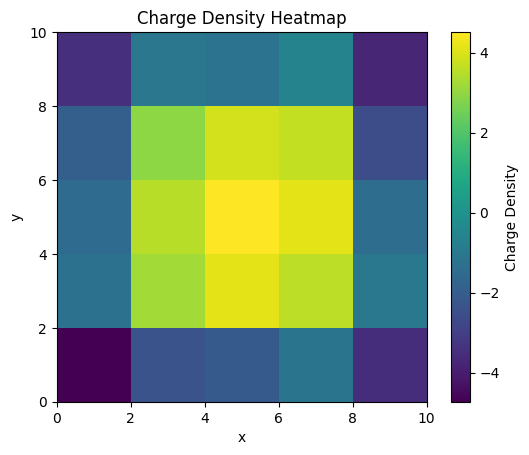

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [9.48447522e+00 9.08139122e+00 7.02899220e+00 7.68529873e+00
 8.72704630e+00 9.44924577e-01 1.16755924e+00 4.71650779e-01
 6.94922974e+00 2.62120799e+00 2.40289625e+00 4.41149469e+00
 6.77467112e+00 6.98859081e+00 8.91361556e+00 7.42737048e+00
 3.01116814e+00 9.34078334e+00 9.43269352e+00 6.93506315e+00
 6.74551806e+00 3.70680058e-01 9.88617762e+00 6.80779544e+00
 9.76914833e+00 1.75407935e+00 4.21055854e+00 7.54067671e+00
 8.24918743e+00 1.06819629e-01 1.34561760e+00 3.33355923e+00
 4.36004070e+00 9.52760222e+00 2.91337074e+00 4.91329695e-01
 5.61746586e+00 7.05045637e+00 9.56782806e+00 2.69948413e+00
 4.43238700e+00 8.13411451e+00 6.02236443e+00 4.70516949e+00
 4.36372126e+00 3.98709758e+00 4.59795310e+00 5.45337837e+00
 8.50104725e+00 6.30764114e+00 9.65789462e+00 7.48026492e+00
 9.00916713e+00 3.32520616e+00 5.37878622e+00 1.57895541e+00
 7.47110760e-01 5.94639974e+00 8.00430117e+00 4.65840165e+00
 6.23656647e-01 7.55845556e+00 5.757208

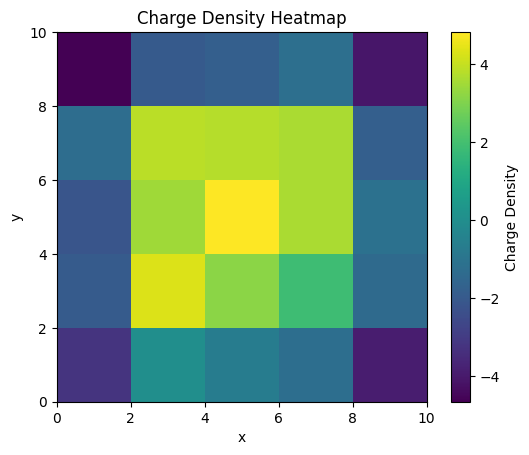

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [6.821073   6.38612826 4.33458555 5.00256953 5.97381376 8.22966237
 8.42089614 7.61180127 4.11203712 9.78831641 9.66891356 1.75071309
 3.98050959 4.28067643 6.06037067 4.64253891 0.26366982 6.67807614
 6.68880977 4.08957827 3.92008813 7.67385953 7.13361926 4.0553981
 7.08066701 9.07876396 1.4752273  4.79188546 5.43031258 7.27882587
 8.67769346 0.52814134 1.5847494  6.83900376 0.2281038  7.77909539
 2.86380514 4.33411184 6.74990749 9.92652939 1.74297284 5.30205546
 3.20708545 1.88997728 1.54624838 1.18088249 1.8999422  2.644367
 5.81756488 3.48602522 6.89552987 4.81030608 6.19529441 0.55928644
 2.7005423  8.77521751 7.99142699 3.25454078 5.20285354 1.81010549
 7.83894597 4.72654733 2.96186273 9.84064542 7.93787058 8.85123298
 6.90373035 1.11235129 6.65949848 3.44571012 4.6480715  0.60717076
 2.56949702 4.31052218 0.42665735 8.67894636 8.73195391 8.60133844
 5.19995364 2.24648165 8.90077834 5.05579771 2.40633563 8.60157075
 2.81887901 4.05127

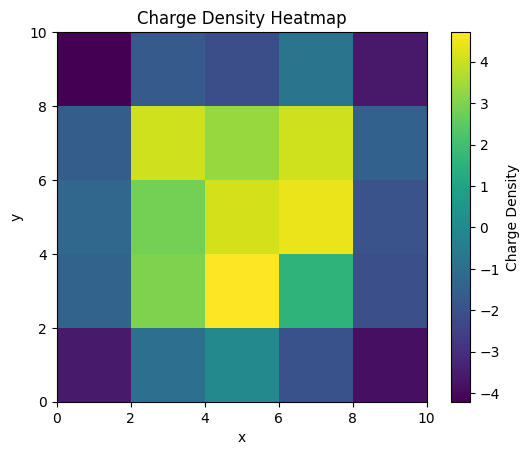

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [8.20822563e+00 7.74142014e+00 5.69073375e+00 6.37039518e+00
 7.27113606e+00 9.56495501e+00 9.72478789e+00 8.80250661e+00
 5.32539934e+00 1.00597968e+00 9.85485703e-01 3.14048633e+00
 5.23690290e+00 5.62331689e+00 7.25768062e+00 5.90826218e+00
 1.56672635e+00 8.06592378e+00 7.99548087e+00 5.29464823e+00
 5.14521304e+00 9.02759385e+00 8.43161575e+00 5.35355560e+00
 8.44274054e+00 4.54003406e-01 2.79045090e+00 6.09364905e+00
 6.66199257e+00 8.50138695e+00 6.03241593e-02 1.77327830e+00
 2.86001296e+00 8.20096015e+00 1.59339171e+00 9.11741592e+00
 4.16069927e+00 5.66832216e+00 7.98254177e+00 1.20412949e+00
 3.10411351e+00 6.52055125e+00 4.44236130e+00 3.12533992e+00
 2.77933034e+00 2.42522223e+00 3.25248615e+00 3.88591046e+00
 7.18463736e+00 4.71496413e+00 8.18371997e+00 6.19090210e+00
 7.43197653e+00 1.84392156e+00 4.07285323e+00 2.20344523e-02
 9.28629807e+00 4.61323667e+00 6.45196074e+00 3.01236417e+00
 9.10479014e+00 5.94519395e+00 4.217072

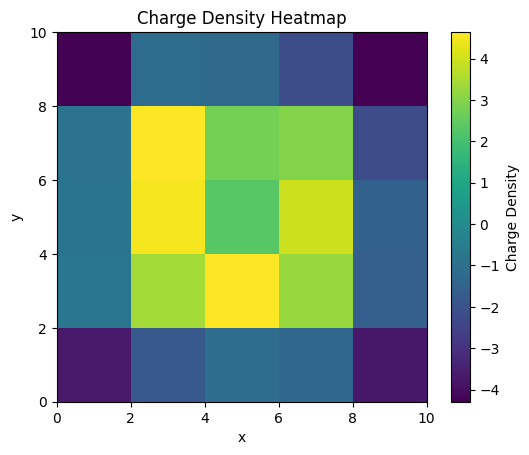

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [5.36302732 4.8643611  2.81453101 3.5058699  4.33610743 6.66789672
 6.7963287  5.76086102 2.30641063 7.99129202 8.06970692 0.29790865
 2.26094529 2.73360643 4.22263965 2.94163453 8.63743195 5.2214205
 5.06980104 2.26736726 2.13798702 6.14897725 5.49726131 2.41936217
 5.57246314 7.59689193 9.87332357 3.16306172 3.66132164 5.49159711
 7.21060393 8.78606432 9.90292558 5.33056562 8.72632869 6.22338553
 1.22524247 2.77018155 4.98282512 8.24937867 0.23290326 3.50669612
 1.44528623 0.12835162 9.78006138 9.43721105 0.37267917 0.89510301
 4.31935891 1.71155213 5.23955914 3.33914718 4.43630772 8.89620576
 1.21281323 7.03650047 6.34881822 1.73958163 3.46871702 9.98227192
 6.13828338 2.93148965 1.23993096 8.23690012 6.47303226 7.39500349
 5.24687687 9.33257332 4.89432311 1.82323981 3.0493321  8.9504182
 0.93204876 2.72051461 8.93701312 7.07696106 7.18717378 6.87842831
 3.41417853 0.54008189 7.2882378  3.32628768 0.73170532 6.99161039
 1.11676052 2.2028

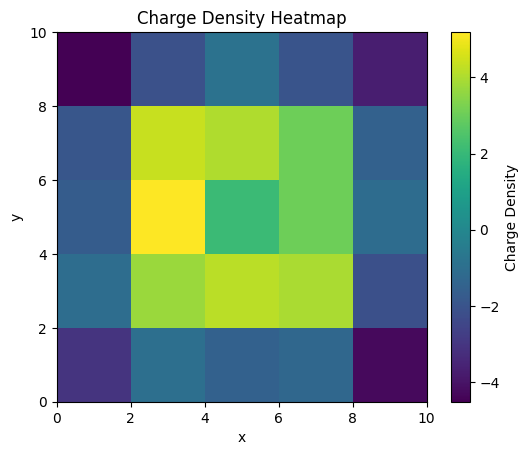

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [6.58524958 6.05472261 4.00574884 4.70876518 5.46849937 7.83825899
 7.93529008 6.78663599 3.35484248 9.04402492 9.2213487  1.52275153
 3.35240823 3.91131652 5.25501923 4.04242744 9.7755581  6.44433778
 6.21154176 3.30750686 3.19818156 7.3377812  6.63032743 3.55258931
 6.7696063  8.80720101 1.0236168  4.29989495 4.72807126 6.54922783
 8.42830427 9.86627091 1.01325877 6.52759164 9.92668623 7.3967757
 2.35720623 3.9394615  6.05052903 9.36204841 1.42911357 4.56026154
 2.51563172 1.19878389 0.84821297 0.51662043 1.56029275 1.97171611
 5.52150103 2.77556068 6.36281887 4.55481283 5.50805947 0.01591051
 2.42019379 8.11838704 7.47875893 2.93334715 4.55289386 1.01960023
 7.23919717 3.9852059  2.33021016 9.38627257 7.6918582  8.61813385
 6.36969522 0.39392942 5.96298053 2.96324975 4.20120749 0.07328702
 2.06456973 3.87675591 0.14343609 8.22721351 8.36602882 7.96821834
 4.47253608 1.6381271  8.43321262 4.41277776 1.84563527 8.13787531
 2.21694637 3.229

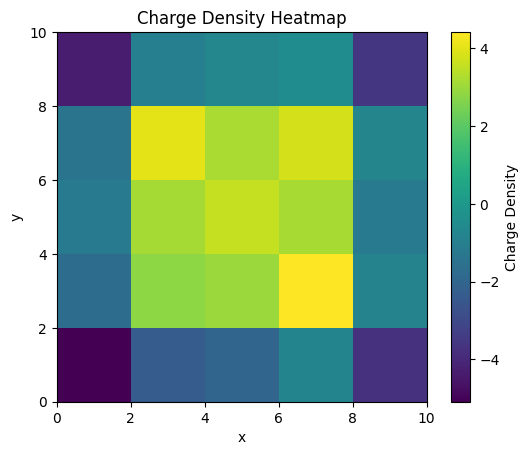

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [1.82797411 1.2655864  9.21746894 9.93216274 0.62139357 3.02912354
 3.09475373 1.83291323 8.42377661 4.11726009 4.39349275 6.76809668
 8.46437346 9.10952889 0.30790109 9.16372262 4.93418653 1.68775733
 1.37378477 8.36814872 8.27887838 2.54708742 1.78389582 8.70631872
 1.98725174 4.03801237 6.1944123  9.45723045 9.81532315 1.62736082
 3.66650687 4.96697977 6.14409423 1.74511993 5.14754604 2.59066814
 7.50967227 9.12924373 1.13873521 4.49522042 6.64582615 9.63432924
 7.60647948 6.28971843 5.93686684 5.61653209 6.76840861 7.06883148
 0.74414541 7.8600715  1.50658087 9.79098074 0.60031349 5.15611754
 7.64807662 3.22077589 2.62920192 8.14761494 9.65757298 6.07743082
 2.36061325 9.05942443 7.44099165 4.55614729 2.93118641 3.86176648
 1.51301584 5.47578781 1.05214021 8.12376197 9.37358516 5.21665811
 7.21759297 9.05349949 5.37036135 3.39796823 3.56538612 3.07851065
 9.55139589 6.75667459 3.59868972 9.51977011 6.98006748 3.30464251
 7.3376345  8.27

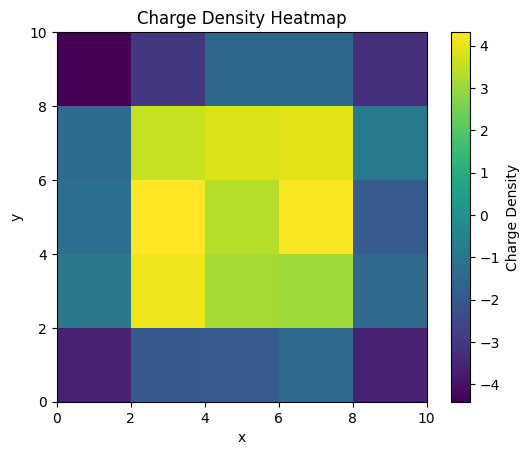

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [3.13296536 2.53871691 0.49145577 1.21782702 1.8365545  4.28225481
 4.3164841  2.94145719 9.55497746 5.25276199 5.62790353 8.07570855
 9.6386054  0.37000799 1.42304967 0.34728452 6.15508169 2.9934436
 2.59829449 9.49105731 9.42184192 3.81866037 2.99973094 9.92231485
 3.26716389 5.33109045 7.42747453 0.67683268 0.96484178 2.76776053
 4.9669762  6.12995535 7.33719641 3.02491495 6.43067258 3.84682731
 8.72440503 0.38129267 2.28920812 5.69065915 7.92480545 0.77066366
 8.75959397 7.4429197  7.08778743 6.77871046 8.03879119 8.22821358
 2.02905652 9.00684905 2.7126096  1.08941539 1.75483424 6.35859129
 8.93822618 4.38543146 3.84191163 9.42414946 0.82451881 7.19752813
 3.54429604 0.19590968 8.61403985 5.78828873 4.23278134 5.16766583
 2.71860319 6.61991291 2.20356662 9.3465409  0.60822955 6.42229592
 8.43288294 0.2925098  6.65955332 4.63098967 4.82701015 4.25106968
 0.69252243 7.9374888  4.82643354 0.68902919 8.17676642 4.53367642
 8.52058934 9.387

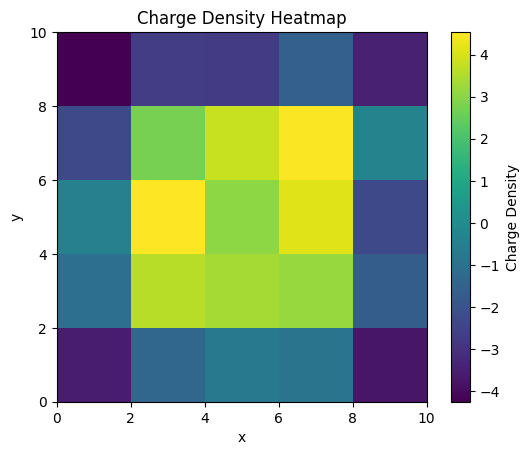

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [2.79190755 2.16579836 0.11939353 0.85744223 1.40566637 3.88933702
 3.89216541 2.4039521  9.04012924 4.74221482 5.21626525 7.73727136
 9.16678828 9.98443802 0.89214919 9.88479736 5.72992778 2.65308082
 2.17675516 8.96791684 8.9187564  3.44418426 2.56951699 9.49226192
 2.90102699 4.97811946 7.0144877  0.25038584 0.46831133 2.26211119
 4.62139647 5.64688187 6.88424953 2.65866091 6.06775005 3.45693742
 8.29308873 9.98729256 1.79363196 5.24004882 7.5577357  0.26094902
 8.2666594  6.9500719  6.59265895 6.29483978 7.6631247  7.74154661
 1.66791857 8.50757753 2.27258927 0.74180097 1.26330592 5.91501598
 8.58232667 3.90403797 3.40857227 9.05463492 0.34541559 6.67157638
 3.08192978 9.68634587 8.141039   5.37438112 3.88832722 4.82751612
 2.27814148 6.11798896 1.70894397 8.92327078 0.19682488 5.98188467
 8.00212384 9.88547104 6.30269624 4.21796206 4.44258512 3.77757964
 0.18759991 7.47225395 4.40812831 0.21223921 7.7274163  4.11666128
 8.05749513 8.85

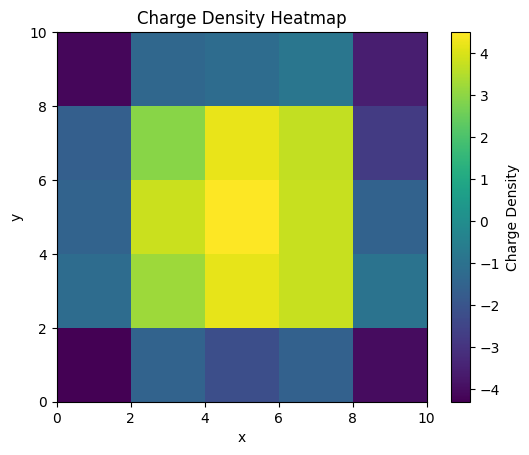

 POSITION X COORDINATES FOR EACH ITERATIONS 
 [0.20940297 9.55143303 7.50588452 8.25561067 8.73333147 1.25497245
 1.22639995 9.62500023 6.28383425 1.99022088 2.56318018 5.1573874
 6.45352439 7.35742127 8.11980193 7.18086343 3.0633271  0.07127125
 9.51376905 6.2033296  6.1742241  0.82826137 9.89785627 6.82076221
 0.29344331 2.38370171 4.36005409 7.58249223 7.73033412 9.51501506
 2.03436996 2.92236161 4.18985587 0.05096009 3.46338075 0.82560074
 5.62032565 7.35184567 9.05660903 2.54799172 4.94921917 7.50978761
 5.53227804 4.21577733 3.85608371 3.56952232 5.04601144 5.01343287
 9.06533384 5.76685924 9.59112216 8.15273977 8.53033083 3.2299939
 5.98498039 1.1811977  0.73378614 6.4436736  7.62486558 3.90417785
 0.37811674 6.93533528 5.42659137 2.71902672 1.30242631 2.24591963
 9.59623299 3.37461823 8.97287454 6.25855388 7.54397343 3.30002665
 5.32991797 7.2369855  3.70439237 1.56348767 1.81671331 1.06264283
 7.44123061 4.76557233 1.74837629 7.49400244 5.03661941 1.45819936
 5.35295414 6.0731

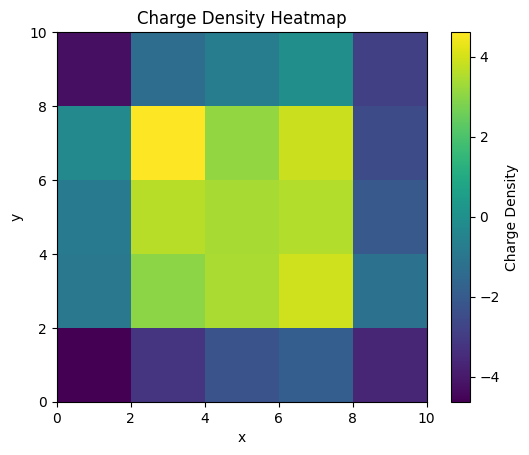

In [136]:
for step in range(n_step):
    pos_x_list = position_x
    print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)
    #position_x, position_y = periodic_particles(position_x, position_y, length)

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
    rho_total = background_charge_density + rho_electron

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vx_half = vel_x + (0.5 * dt * acceleration_x)
    vy_half = vel_y + (0.5 * dt * acceleration_y)

    position_x += vx_half * dt
    position_y += vy_half * dt

    #position_x, position_y = periodic_particles(position_x, position_y, length)

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
    rho_total = background_charge_density + rho_electron

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vel_x = vx_half + 0.5 * dt * acceleration_x
    vel_y = vy_half + 0.5 * dt * acceleration_y

    plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
    plt.colorbar(label='Charge Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Charge Density Heatmap')
    plt.show()

    #vel_x_list.append(vel_x)
    #rho_total_list.append(rho_total)

    t += dt

In [137]:
print("END POSITION X COORDINATES : \n ",pos_x_list)

END POSITION X COORDINATES : 
  [2.99705797e+00 2.30722730e+00 2.62535097e-01 1.02393870e+00
 1.43115615e+00 3.99076747e+00 3.93079408e+00 2.21620795e+00
 8.89769886e+00 4.60838653e+00 5.28025471e+00 7.94766302e+00
 9.11042009e+00 1.00564117e-01 7.17614264e-01 9.84708909e+00
 5.76688601e+00 2.85962128e+00 2.22094253e+00 8.80890194e+00
 8.79985139e+00 3.58249807e+00 2.59635514e+00 9.51942209e+00
 3.05601922e+00 5.15944354e+00 7.07578007e+00 2.84758203e-01
 3.62516490e-01 2.13807853e+00 4.81750305e+00 5.56800095e+00
 6.86562181e+00 2.81341886e+00 6.22917104e+00 3.56442366e+00
 8.31772216e+00 8.65583699e-02 1.68974569e+00 5.22609421e+00
 7.71086222e+00 1.28785782e-01 8.16805628e+00 6.85164235e+00
 6.48966805e+00 6.21436445e+00 7.79905777e+00 7.65547872e+00
 1.83290870e+00 8.39630055e+00 2.27981464e+00 9.33838164e-01
 1.16751533e+00 5.91513140e+00 8.75779370e+00 3.82851702e+00
 3.42915960e+00 9.20287187e+00 2.74475174e-01 6.50693892e+00
 3.04446329e+00 9.55448428e+00 8.08230332e+00 5.43383

In [138]:
'''


plt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()
'''

"\n\n\nplt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n"